What day and time are the most popluar times for videos to get the most virality?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import plotly.express as px

In [2]:
def clean_transform_extract(csv_file_path, json_file_path, cleaned_csv_file_path):
    '''
    Purpose:
    - Clean: Address errors, duplicates, or NaN/Empty values, if applicable
    - Transform: Convert columns to workable dtype or workable format
    - Extract: Pull relevant data from json df and return it to csv df

    Paramenters:
    - yt_df: the `USvideos.csv` that will serve as the primary df during case study
    - yt_json_df: the `US_category_id.json` that serves as the mechanism for extracting
    category id, name key, value pairs and returning to `yt_df`

    Actions:
    - See comments below 

    Outputs:
    - Cleaned and transformed `yt_df`
    - An array of all unique tags in the `yt_df['tags']` column
    - A dictionary of all `category_id`, `category_name` key, value pairs
    '''
    import pandas as pd
    yt_df = pd.read_csv(csv_file_path)
    yt_json_df = pd.read_json(json_file_path)

    # Converts datetime columns to datetime dtypes based on specific formats
    # Converts `publish_time to UTC datetime format`
    yt_df['publish_time'] = pd.to_datetime(
        arg=yt_df['publish_time'], 
        errors='coerce',
        )
    # Converts `trending_date` to datetime format (`yy-dd-mm`-based)
    yt_df['trending_date'] = pd.to_datetime(
        arg=yt_df['trending_date'], 
        errors='coerce', 
        format='%y.%d.%m',
        )
    
    # Category names
    # Creates a dictionary of category id (keys) and names (values)
    cat_id_name_dict = dict(
        zip(
            yt_json_df['items'].str.get('id').astype(int),
            yt_json_df['items'].str.get('snippet').str.get('title')
            )
        )    
    # Inserts category names into a new column using the dictionary
    # and `category_id` column as a map
    yt_df.insert(
        loc=5, 
        column='category_name', 
        value=yt_df['category_id'].map(cat_id_name_dict)
        )

    # Inserts three new columns based on the `publish_time` column
    # Inserts month column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 1, 
        column='publish_time_month', 
        value=yt_df['publish_time'].dt.month_name()
        )
    # Inserts day of week name column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 2, 
        column='publish_time_day_name', 
        value=yt_df['publish_time'].dt.day_name()
        )
    # Inserts date column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 3, 
        column='publish_time_date', 
        value=yt_df['publish_time'].dt.date
        )

    # Inserts two new columns based on the `trending_date` column
    # Inserts month column
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 1, 
        column='trending_date_month', 
        value=yt_df['trending_date'].dt.month_name()
        )
    # Inserts day of week name column
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 2, 
        column='trending_date_day_name', 
        value=yt_df['trending_date'].dt.day_name()
        )
    
    range_series = (
    yt_df.groupby('video_id')['trending_date'].max()
      - yt_df.groupby('video_id')['trending_date'].min()
        ).dt.days
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 3, 
        column='num_days_trending', 
        value=yt_df['video_id'].map(range_series)
    )

    # Replaces the values in the `tags` column
    # with a list of individual tags as opposed to a single string
    yt_df['tags'] = yt_df['tags'].str.split('|')
    tag_arr = yt_df['tags'].explode().str.strip('"').str.lower().value_counts(ascending=False).drop('[none]')

    yt_df.to_csv(cleaned_csv_file_path, index=False)
   
    # Prints a message containing instructions on what to do next
    print(f"In a separate cell block, execute the following line of code: clean_yt_df = pd.read_csv('{cleaned_csv_file_path}')")
   
    # Returns the tag_dict the dictionary
    return yt_df, tag_arr

In [3]:
new_yt_df, tag_arr = clean_transform_extract('../.gitignore/data/USvideos.csv', '../.gitignore/data/US_category_id.json', '../.gitignore/data/cleaned_yt_df.csv')

In a separate cell block, execute the following line of code: clean_yt_df = pd.read_csv('../.gitignore/data/cleaned_yt_df.csv')


In [4]:
new_yt_df.head()

,video_id,trending_date,trending_date_month,trending_date_day_name,num_days_trending,title,channel_title,category_id,category_name,publish_time,...,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,November,Tuesday,6,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,People & Blogs,2017-11-13 17:13:01+00:00,...,[SHANtell martin],748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,November,Tuesday,6,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,Entertainment,2017-11-13 07:30:00+00:00,...,"[last week tonight trump presidency, ""last wee...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,November,Tuesday,6,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,Comedy,2017-11-12 19:05:24+00:00,...,"[racist superman, ""rudy"", ""mancuso"", ""king"", ""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,November,Tuesday,6,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,Entertainment,2017-11-13 11:00:04+00:00,...,"[rhett and link, ""gmm"", ""good mythical morning...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,November,Tuesday,5,I Dare You: GOING BALD!?,nigahiga,24,Entertainment,2017-11-12 18:01:41+00:00,...,"[ryan, ""higa"", ""higatv"", ""nigahiga"", ""i dare y...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [5]:
new_yt_df_sorted = new_yt_df.sort_values('views', ascending=False)

In [6]:
new_yt_df_numeric = new_yt_df_sorted[['publish_time', 'publish_time_date', 'trending_date_day_name', 'views', 'likes', 'video_id']]
new_yt_df_numeric[0:100]

,publish_time,publish_time_date,trending_date_day_name,views,likes,video_id
38547,2018-05-06 04:00:07+00:00,2018-05-06,Saturday,225211923,5023450,VYOjWnS4cMY
38345,2018-05-06 04:00:07+00:00,2018-05-06,Friday,220490543,4962403,VYOjWnS4cMY
38146,2018-05-06 04:00:07+00:00,2018-05-06,Thursday,217750076,4934188,VYOjWnS4cMY
37935,2018-05-06 04:00:07+00:00,2018-05-06,Wednesday,210338856,4836448,VYOjWnS4cMY
37730,2018-05-06 04:00:07+00:00,2018-05-06,Tuesday,205643016,4776680,VYOjWnS4cMY
...,...,...,...,...,...,...
35976,2018-05-18 09:00:02+00:00,2018-05-18,Monday,65396157,4750245,7C2z4GqqS5E
39624,2018-05-29 14:05:10+00:00,2018-05-29,Friday,65149069,1580402,xTlNMmZKwpA
32294,2018-04-20 10:40:51+00:00,2018-04-20,Wednesday,65110757,1061369,zEf423kYfqk
24673,2018-03-09 11:00:01+00:00,2018-03-09,Monday,64594661,714816,-BQJo3vK8O8


Childish Gambino - This is America (Official Video):
View Count: 225211923
Likes: 5023450
Published: 2018-05-06 04:00:07+00:00
Trending: 2018-06-02, 2018-06-01, 2018-05-31, 2018-05-30, 2018-05-29

24964	2018-03-20 15:00:19+00:00	2018-03-20	Wednesday	291118	13259

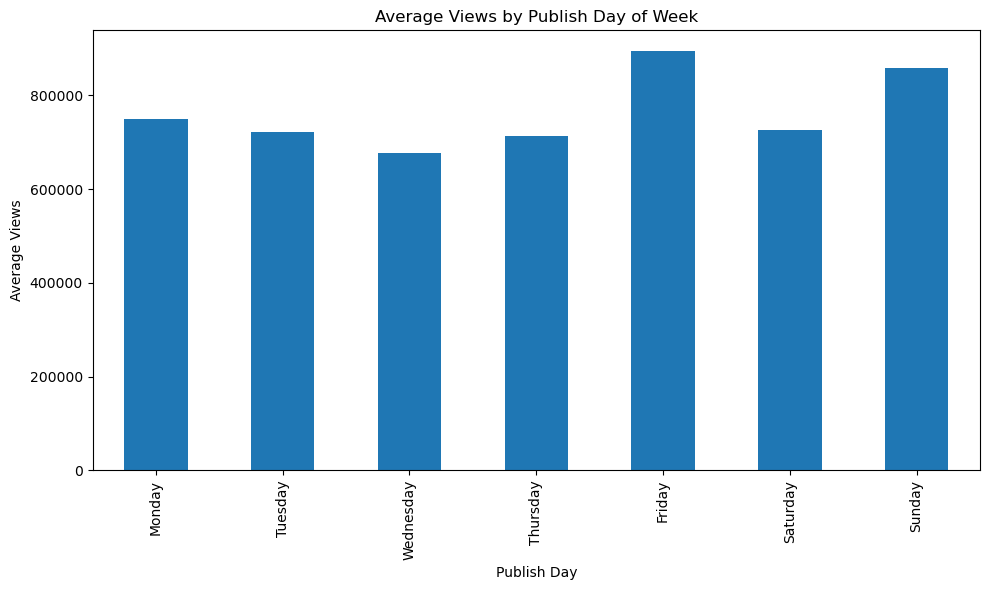

In [12]:
unique_videos = new_yt_df.drop_duplicates(subset='video_id')
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pop_by_day = (
    unique_videos
      .groupby('publish_time_day_name')['views']
      .mean()
      .reindex(day_order)
)
fig, ax = plt.subplots(figsize=(10,6))
pop_by_day.plot(kind='bar', ax=ax)
ax.set_title('Average Views by Publish Day of Week')
ax.set_xlabel('Publish Day')
ax.set_ylabel('Average Views')
plt.tight_layout()
plt.show()

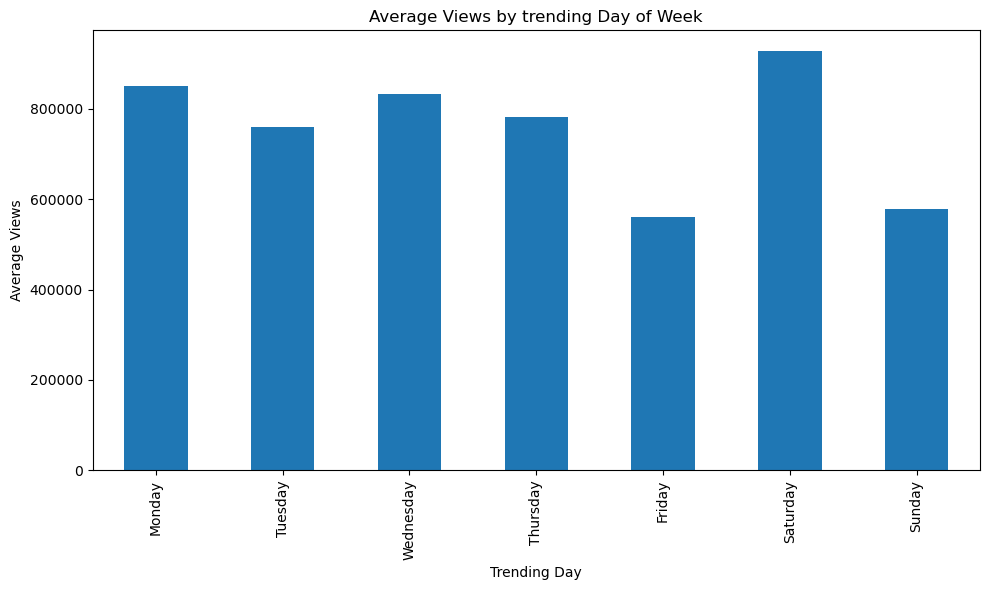

In [16]:
unique_videos = new_yt_df.drop_duplicates(subset='video_id')
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pop_by_day = (
    unique_videos
      .groupby('trending_date_day_name')['views']
      .mean()
      .reindex(day_order)
)
fig, ax = plt.subplots(figsize=(10,6))
pop_by_day.plot(kind='bar', ax=ax)
ax.set_title('Average Views by trending Day of Week')
ax.set_xlabel('Trending Day')
ax.set_ylabel('Average Views')
plt.tight_layout()
plt.show()